[*********************100%***********************]  1 of 1 completed
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Epoch 1/20


C:\Users\Vinayak Chauhan\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2768/2768 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - loss: 0.0012
Epoch 2/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 3.5696e-04
Epoch 3/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 1.7763e-04
Epoch 4/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 1.3561e-04
Epoch 5/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 1.6271e-04
Epoch 6/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 9.4965e-05
Epoch 7/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - loss: 9.2503e-05
Epoch 8/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 1.0088e-04
Epoch 9/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - loss: 1.2825e-04
Epoch 10/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - loss: 7.1901e-05
Epoch 11/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - loss: 8.5996e-05
Epoch 12/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 7.2277e-05
Epoch 13/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - loss: 9.2182e-05
Epoch 14/20
2768/2768 ━━━━━━━━━━━━━━

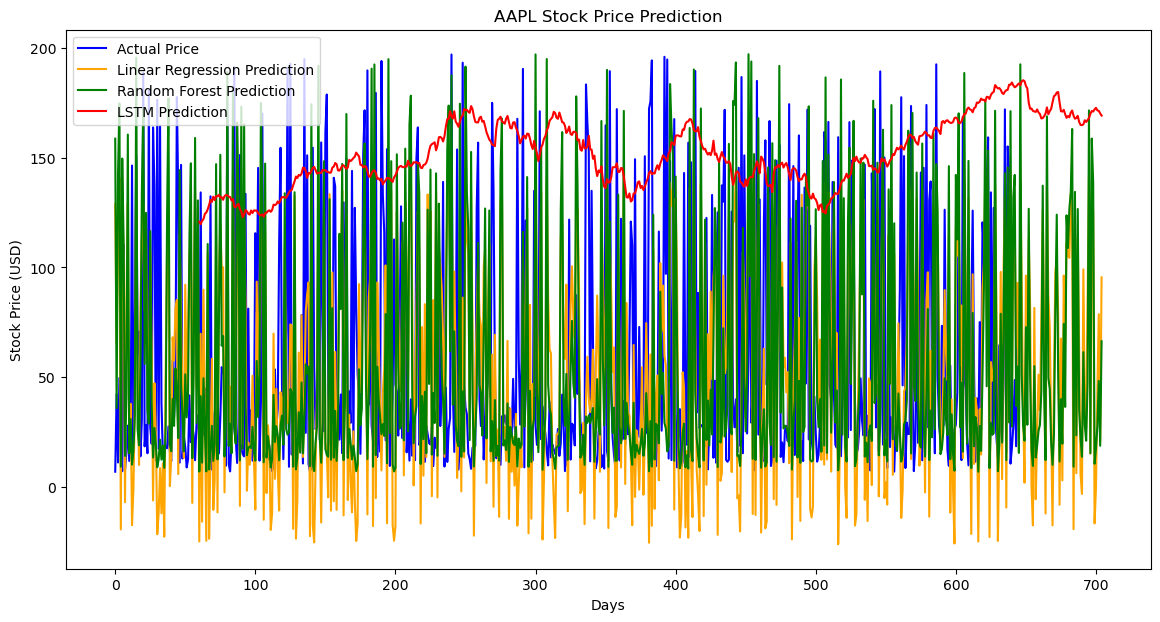

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# 1. Download Stock Data from Yahoo Finance
ticker_symbol = 'AAPL'  # Apple Inc.
start_date = '2010-01-01'
end_date = '2023-12-31'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# 2. Data Preprocessing
stock_data = stock_data.dropna()
data = stock_data.reset_index()
data['Day'] = data.index  # Day is the index (0 to len(data))
X = data[['Day']]
y = data['Close']

# Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

# 4. Random Forest Model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
forest_pred = forest_model.predict(X_test)

# 5. LSTM Model Preparation
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(y.values.reshape(-1, 1))

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_lstm, y_lstm = create_dataset(scaled_data, look_back)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

# Train-Test Split for LSTM
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, batch_size=1, epochs=20)

# LSTM Prediction
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred)

# 6. Model Evaluation Function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Evaluate Linear and Random Forest Models
linear_mse, linear_rmse, linear_r2 = evaluate_model(y_test, linear_pred)
forest_mse, forest_rmse, forest_r2 = evaluate_model(y_test, forest_pred)

# Align y_test with lstm_pred and ensure lengths match
y_test_lstm = y_test.iloc[look_back:].values[:len(lstm_pred)]
if len(y_test_lstm) != len(lstm_pred):
    min_len = min(len(y_test_lstm), len(lstm_pred))
    y_test_lstm = y_test_lstm[:min_len]
    lstm_pred = lstm_pred[:min_len]

# Evaluate LSTM Model
lstm_mse, lstm_rmse, lstm_r2 = evaluate_model(y_test_lstm, lstm_pred)

# 7. Print Results
print("Linear Regression - MSE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}".format(linear_mse, linear_rmse, linear_r2))
print("Random Forest - MSE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}".format(forest_mse, forest_rmse, forest_r2))
print("LSTM - MSE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}".format(lstm_mse, lstm_rmse, lstm_r2))

# 8. Visualization of Results
plt.figure(figsize=(14, 7))
plt.plot(y_test.iloc[look_back:].values, label='Actual Price', color='blue')
plt.plot(linear_pred, label='Linear Regression Prediction', color='orange')
plt.plot(forest_pred, label='Random Forest Prediction', color='green')
plt.plot(np.arange(look_back, look_back + len(lstm_pred)), lstm_pred, label='LSTM Prediction', color='red')
plt.title(f'{ticker_symbol} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()